# Regression with Insurance Data: Predict insurance premiums based on various factors... by Anand CJ

# Start

# Set up: Huge data files uploaded as kaggle datasets and downloaded to read from google collab

In [10]:
# !pip install kaggle

In [11]:
# !rm -rf /root/.kaggle/kaggle.json

In [12]:
# import shutil
# import os

# # Create a Kaggle directory
# os.makedirs("/root/.kaggle", exist_ok=True)

# # Move kaggle.json to the directory
# shutil.move("/content/kaggle.json", "/root/.kaggle/")

# # Set permissions
# os.chmod("/root/.kaggle/kaggle.json", 600)

# print("Kaggle API key configured successfully!")

In [13]:
################################################################################
## Set the path using google collab note book to the dataset in kaggle  ##
################################################################################
!kaggle datasets download -d cjanand/pt-insurance-premium-dataset --unzip -p /content/data

Dataset URL: https://www.kaggle.com/datasets/cjanand/pt-insurance-premium-dataset
License(s): unknown
 93% 73.0M/78.3M [00:03<00:00, 25.1MB/s]
100% 78.3M/78.3M [00:03<00:00, 24.0MB/s]


## Import Libraries

In [14]:
##########################################
## Import required python libraries ##
##########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.tree import plot_tree

## Import Data

In [15]:
############################################################
## Load Data into train, test and submission df ##
############################################################
train_df = pd.read_csv("/content/data/train.csv")
test_df = pd.read_csv("/content/data/test.csv")
sample_submission_df = pd.read_csv("/content/data/sample_submission.csv")

# Display first few rows
print(train_df.shape, test_df.shape, sample_submission_df.shape)

(1200000, 21) (800000, 20) (800000, 2)


# Data Pre-Processing, Exploratory Data Analysis

##Explore the Data

In [16]:
##################################################################################################
## Explore the Data. Understanding the structure and content of training and test datasets ##
##################################################################################################
print(set(train_df.columns) - set(test_df.columns))
print(' Train columns ', train_df.columns)
print(' Train shape ', train_df.shape)
print(' Train feature types ', train_df.dtypes)
print(' Test columns ', test_df.columns)
print(' Test shape ', test_df.shape)
print(' Test feature types ', test_df.dtypes)


{'Premium Amount'}
 Train columns  Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')
 Train shape  (1200000, 21)
 Train feature types  id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date      

In [17]:
#################################################################################
## Explore the Data. # Distribution of all numerical features ##
#################################################################################
############ Histogram Plots to check on distributions ############
##### Numerical features ####
# Previous Claims
# Credit Score
# Number of Dependents
# Health Score
# Annual Income
# Age
# Vehicle Age
# Insurance Duration

# sns.histplot(train_df['Previous Claims'], bins=20, kde=True)
# plt.title('Histogram of Previous Claims')
# plt.show()

In [18]:
#################################################################################
## Explore the Data. # Frequency distribution of all categorical features ##
#################################################################################
# Count unique values for categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

print(categorical_cols)
for col in categorical_cols:
    print(f"{col} Distribution:\n{train_df[col].value_counts()}\n")


Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')
Gender Distribution:
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Marital Status Distribution:
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Education Level Distribution:
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Occupation Distribution:
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Location Distribution:
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Policy Type Distribution:
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Pol

In [19]:
#################################################################################
## Explore the Data. # Distribution of all categorical features by Plots ##
#################################################################################
##### Categorical features ####
# Occupation
# Customer Feedback
# Marital Status
# Gender
# Education Level
# Location
# Policy Type
# Exercise Frequency
# Property Type
# Smoking Status

############ Box Plots to check on distributions ############
# plt.figure(figsize=(10, 6))
# sns.boxplot(x=train_df['Smoking Status'], y=train_df['Premium Amount'])
# plt.title('Smoking Status vs Premium Amount')
# plt.xlabel('Smoking Status')
# plt.ylabel('Premium Amount')
# plt.xticks(rotation=45)  # Rotate labels if needed
# plt.show()

# ############ Scatter Plots to check on distributions ############
# plt.figure(figsize=(10, 6))
# plt.scatter(train_df['Smoking Status'], train_df['Premium Amount'])
# plt.title('Smoking Status vs Premium')
# plt.xlabel('Smoking Status')
# plt.ylabel('Premium')
# plt.show()

In [20]:
#########################################################################
## Explore the Data. # Compute skewness for all numerical features #
#########################################################################
# List of numerical columns to check
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
skew_values = train_df[numerical_cols].skew().sort_values(ascending=False)
print(skew_values.round(3))

# Set a threshold for transformation
threshold = 0.5  # Modify as needed

# Identify features needing transformation
skewed_features = skew_values[abs(skew_values) > threshold].index
print("Features requiring transformation:", skewed_features)

Annual Income           1.470
Premium Amount          1.241
Previous Claims         0.905
Health Score            0.282
id                      0.000
Insurance Duration     -0.009
Age                    -0.013
Number of Dependents   -0.013
Vehicle Age            -0.020
Credit Score           -0.114
dtype: float64
Features requiring transformation: Index(['Annual Income', 'Premium Amount', 'Previous Claims'], dtype='object')


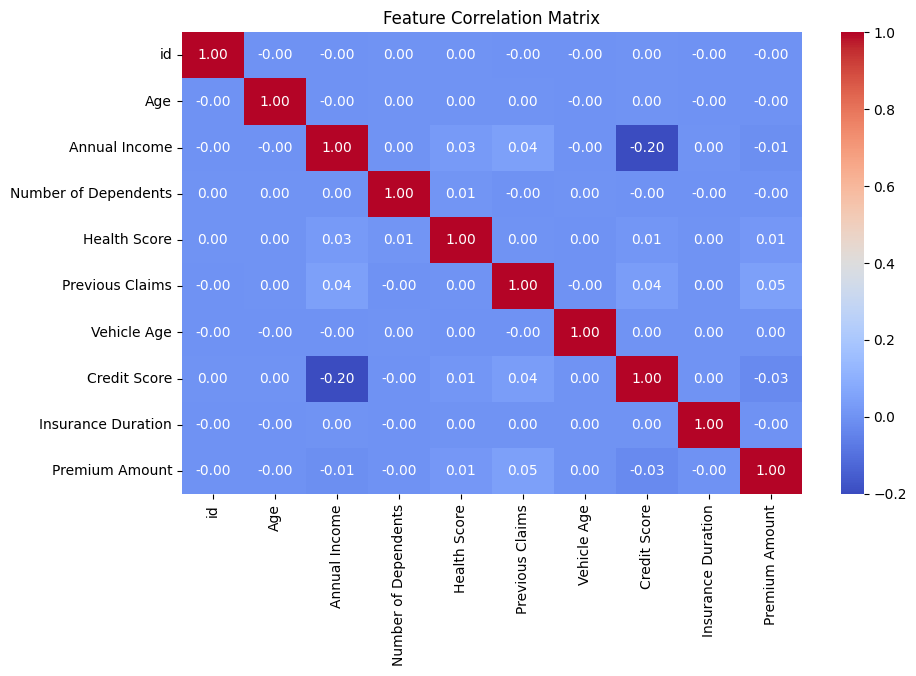

In [21]:
########################################################################################
## Explore the Data. # Compute Correlation for all numerical features with Target #
########################################################################################
# train_df.hist(bins=25, figsize=(20,15))
# plt.show()

# Select only numerical columns
numeric_cols = train_df.select_dtypes(include=['number'])
# Compute the correlation matrix
corr_matrix = numeric_cols.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [22]:
#########################################################################################################
## Explore the Data. # Compute Chi-Square Test for Dependency of Categorical features with Target ##
#########################################################################################################
#Chi-Square for categorical features
from scipy.stats import chi2_contingency
# Count unique values for categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
categorical_cols

def chi_square_test_single(df, feature, target):
  import scipy.stats as stats
  contingency_table = pd.crosstab(df[feature], df[target])  # Create contingency table
  chi2, p, dof, expected = stats.chi2_contingency(contingency_table)  # Perform Chi-Square test

  if p < 0.05:
      significance = "Statisfically Significant"
  else:
      significance = "Not Statisfically Significant"
  return {"Feature": feature, "Chi2 Statistic": chi2, "P-value": p, "Result": significance}

##### Categorical features ####
# Gender
# Marital Status
# Education Level
# Occupation
# Location
# Policy Type
# Customer Feedback
# Smoking Status
# Exercise Frequency
# Property Type

resultchi = chi_square_test_single(train_df, 'Gender', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Marital Status', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Education Level', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Occupation', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Location', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Policy Type', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Customer Feedback', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Smoking Status', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Exercise Frequency', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Property Type', 'Premium Amount')
print(resultchi)

{'Feature': 'Gender', 'Chi2 Statistic': 5400.10388126688, 'P-value': 1.2346445862590775e-09, 'Result': 'Statisfically Significant'}
{'Feature': 'Marital Status', 'Chi2 Statistic': 11296.302830564455, 'P-value': 6.054431134494578e-32, 'Result': 'Statisfically Significant'}
{'Feature': 'Education Level', 'Chi2 Statistic': 16260.40433429763, 'P-value': 8.882550062892367e-27, 'Result': 'Statisfically Significant'}
{'Feature': 'Occupation', 'Chi2 Statistic': 10791.407602234858, 'P-value': 8.606521113205207e-21, 'Result': 'Statisfically Significant'}
{'Feature': 'Location', 'Chi2 Statistic': 10675.228773641269, 'P-value': 1.5786637562714547e-14, 'Result': 'Statisfically Significant'}
{'Feature': 'Policy Type', 'Chi2 Statistic': 10543.957807989807, 'P-value': 1.0043336915411408e-11, 'Result': 'Statisfically Significant'}
{'Feature': 'Customer Feedback', 'Chi2 Statistic': 10950.525666241949, 'P-value': 3.130419632356064e-22, 'Result': 'Statisfically Significant'}
{'Feature': 'Smoking Status', 

In [23]:
###################################################################################################
## Explore the Data. Understanding missing values of training and test datasets ##
###################################################################################################
print(train_df.isnull().sum().sort_values(ascending = False))
print('======================')
print(test_df.isnull().sum().sort_values(ascending = False))

Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
id                           0
Property Type                0
Exercise Frequency           0
Smoking Status               0
Policy Type                  0
Policy Start Date            0
Location                     0
Education Level              0
Gender                       0
Premium Amount               0
dtype: int64
Previous Claims         242802
Occupation              239125
Credit Score             91451
Number of Dependents     73130
Customer Feedback        52276
Health Score             49449
Annual Income            29860
Age                      12489
Marital Status           12336
Vehicle Age                  3
Insurance Duration        

In [24]:
################################################################################
## Explore the Data. Understanding mean, median for numerical features ##
################################################################################
# Previous Claims
# Occupation
# Credit Score
# Number of Dependents
# Customer Feedback
# Health Score
# Annual Income
# Age
# Marital Status

## Replace any of the above numerical feature in the code below ##
# mean_value = train_df['Number of Dependents'].mean()
# median_value = train_df['Number of Dependents'].median()
# mode_value = train_df['Number of Dependents'].mode()
# print(f"Mean: {mean_value}, Median: {median_value}, Mode {mode_value}")

## Pre-Process the data

# Model development

## Build the Random Forests Model

In [25]:
##########################################################################################################
## X features, y target, Pipeline for model, Train the model, Prediction ##
##########################################################################################################

# Separate Features & Target
X = train_df.drop(columns=['Premium Amount', 'Policy Start Date', 'id', 'Property Type'])
y = train_df['Premium Amount']

# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

#################################################################################
## Data Transformation of Numerical features based on Skewness ##
#################################################################################
# **Manual Transformation** - Apply square root transformation
X_train['Annual Income'] = np.sqrt(X_train['Annual Income'])
X_train['Previous Claims'] = np.sqrt(X_train['Previous Claims'])

X_val['Annual Income'] = np.sqrt(X_val['Annual Income'])
X_val['Previous Claims'] = np.sqrt(X_val['Previous Claims'])

# feature = "Annual Income"
# sns.histplot(train_df[feature], kde=True, bins=30)

# feature = "Previous Claims"
# sns.histplot(train_df[feature], kde=True, bins=30)


################################################################################
## PreProcess the data. Imputing for both numerical and categorical features ##
################################################################################
median_impute_cols = ['Annual Income', 'Previous Claims']
mean_impute_cols = ['Credit Score', 'Health Score', 'Age']
mode_impute_num_cols = ['Number of Dependents']
mode_impute_cat_cols = ['Occupation', 'Customer Feedback', 'Marital Status']

# Apply Imputation
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer_num = SimpleImputer(strategy='most_frequent')
mode_imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[median_impute_cols] = median_imputer.fit_transform(X_train[median_impute_cols])
X_val[median_impute_cols] = median_imputer.transform(X_val[median_impute_cols])

X_train[mean_impute_cols] = mean_imputer.fit_transform(X_train[mean_impute_cols])
X_val[mean_impute_cols] = mean_imputer.transform(X_val[mean_impute_cols])

X_train[mode_impute_num_cols] = mode_imputer_num.fit_transform(X_train[mode_impute_num_cols])
X_val[mode_impute_num_cols] = mode_imputer_num.transform(X_val[mode_impute_num_cols])

X_train[mode_impute_cat_cols] = mode_imputer_cat.fit_transform(X_train[mode_impute_cat_cols])
X_val[mode_impute_cat_cols] = mode_imputer_cat.transform(X_val[mode_impute_cat_cols])

#############################################################################################
## PreProcess the Data. Apply Encoding  to categorical features  ##
#############################################################################################

# Define Encoding Strategies
ordinal_encode_cols = ['Gender', 'Marital Status', 'Education Level', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency']
onehot_encode_cols = list(set(categorical_cols) - set(ordinal_encode_cols))

####### Encoding the columns with Ordinal encoding #######
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[ordinal_encode_cols] = ordinal_encoder.fit_transform(X_train[ordinal_encode_cols])
X_val[ordinal_encode_cols] = ordinal_encoder.transform(X_val[ordinal_encode_cols])

####### Encoding the columns with One hot encoding  #######
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_encode_cols]))
X_val_ohe = pd.DataFrame(onehot_encoder.transform(X_val[onehot_encode_cols]))

# Add back column names after One-Hot Encoding
X_train_ohe.columns = onehot_encoder.get_feature_names_out(onehot_encode_cols)
X_val_ohe.columns = onehot_encoder.get_feature_names_out(onehot_encode_cols)

# Drop original categorical columns and concatenate One-Hot Encoded data
X_train = X_train.drop(columns=onehot_encode_cols).reset_index(drop=True)
X_val = X_val.drop(columns=onehot_encode_cols).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_val = pd.concat([X_val, X_val_ohe], axis=1)

#############################################################################################
## PreProcess the Data. Apply Scaling to numerical features  ##
#############################################################################################

# Define Scaling Strategies
minmax_scale_cols = ['Credit Score', 'Vehicle Age', 'Age']
standard_scale_cols = ['Health Score']

# Apply Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_train[minmax_scale_cols] = minmax_scaler.fit_transform(X_train[minmax_scale_cols])
X_val[minmax_scale_cols] = minmax_scaler.transform(X_val[minmax_scale_cols])

# Apply Standard Scaling
standard_scaler = StandardScaler()
X_train[standard_scale_cols] = standard_scaler.fit_transform(X_train[standard_scale_cols])
X_val[standard_scale_cols] = standard_scaler.transform(X_val[standard_scale_cols])

# No scaling applied to 'Number of Dependents' and 'Insurance Duration'

# Display scaled dataset
# train_df.loc[:,['Credit Score','Credit__Score','Vehicle Age','Vehicle__Age', 'Health Score','Health__Score','Age', 'Age__']].head()

# sns.histplot(train_df['Health Score'], bins=20, kde=True)
# plt.title('Histogram of Health Score')
# plt.show()

## Train, Predict and Evaluate Random Forests Model

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, n_iter = 10, cv=3, scoring='r2', n_jobs = -1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
model = random_search.best_estimator_

# Evaluate Model
train_r2 = model.score(X_train, y_train)
valid_r2 = model.score(X_val, y_val)
print(f"Train R2 Score: {train_r2:.4f}")
print(f"Validation R2 Score: {valid_r2:.4f}")

# Predict on Validation Data
y_val_pred = model.predict(X_val)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse:.4f}")


12:04am restarted execution

In [ ]:
# # Train Random Forest Model
# model = RandomForestRegressor(
#     n_estimators=300,  # Increase trees for better generalization
#     max_depth=25,      # Limit depth to prevent overfitting
#     random_state=42
# )
# model.fit(X_train, y_train)

## Random Forests Model performance

## Random Forests model - Feature Importances

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# feature_importances.nlargest(15).plot(kind='barh', figsize=(10, 6))
feature_importances.plot(kind='barh', figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.show()

# Test and Validation

In [ ]:
# test_df.shape
# test_df.head(1)
# # Generate predictions for test data set
# y_test_pred = decision_tree_pipeline.predict(test_df)
# y_test_pred

# Prepare and Save submission file

In [ ]:
# # Save Submission File
# sample_submission['Premium Amount'] = y_test_pred # second column for predicted target values
# sample_submission.to_csv('submission_rf.csv', index=False)
# print("Submission file saved as 'submission_rf.csv'")

# Finish